In [58]:
import tensorflow as tf
import os

In [59]:
#avoid OOM errors by setting cpu memory consumption growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [60]:
# !pip install opencv-python
import cv2#open cv module that allows to do computer vision
import imghdr #for file extension
from matplotlib import pyplot as plt 

Remove dodgy images

In [61]:
data_dir = 'Datasets'

In [62]:
# os.listdir(data_dir)
# os.listdir(os.path.join(data_dir,'happy'))

In [63]:
image_exts = ['jpeg','jpg','bmp','png']

In [64]:
img = cv2.imread(os.path.join('Datasets','happy','_happy_jumping_on_beach-40815.jpg'))

In [65]:
#opencv reads image in BGR and matplotlib reads in RGB
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
# plt.show()

In [66]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

LOAD DATA using keras image data set from directory helper

In [67]:
#?? show documentation
# tf.data.Dataset??

In [68]:
#  tf.keras.utils.image_dataset_from_directory??

In [69]:
import numpy as np
#building data pipeline
data = tf.keras.utils.image_dataset_from_directory('Datasets')

Found 158 files belonging to 2 classes.


In [70]:
#data is a generator hence we cannot directly access data
#as_numpy_iterator allow access generator from data pipeline
data_iterator = data.as_numpy_iterator()#accessing data pipeline with loops

In [71]:
#get random batch from the iterator
batch = data_iterator.next()#grabbing one batch back from data pipeline

In [72]:
batch[0].shape

(32, 256, 256, 3)

In [73]:
batch[1]
#class 0 = happy,1 = sad

array([1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 0, 1])

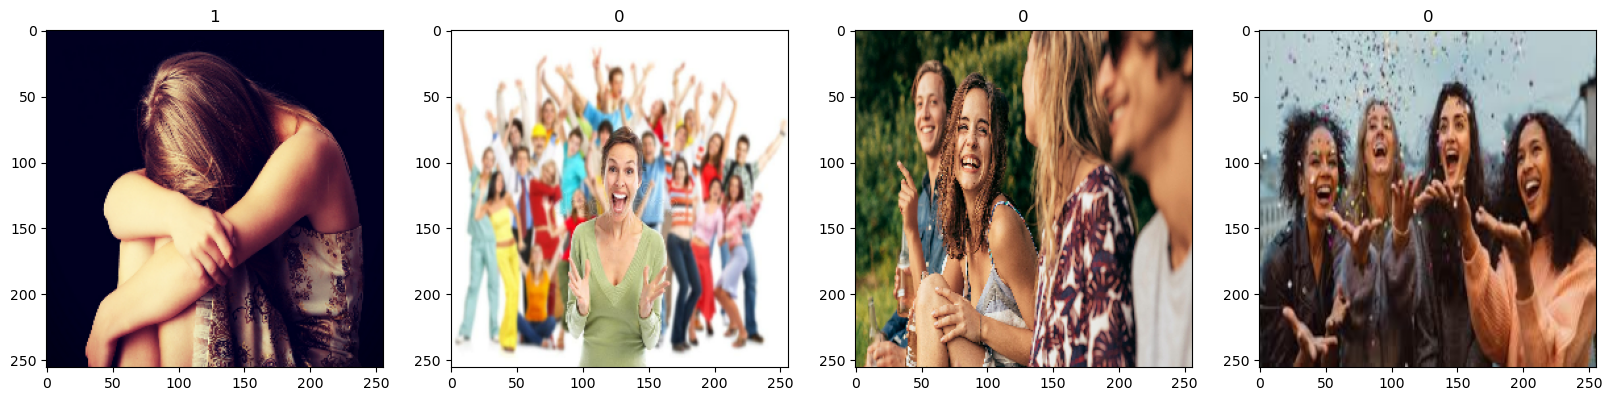

In [74]:
fig,ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing data

scale data

In [75]:
# scaled = batch[0] / 255
# scaled.max()
#idea -> this is to make value small as possible

In [76]:
data = data.map(lambda x,y: (x/255,y))
#data.map allows you to make transformation in pipeline
#x represents images, y= labels
#zip -> to combine a set of features and labels 

In [77]:
scaled_iterator = data.as_numpy_iterator()

In [78]:
batch = scaled_iterator.next()

In [79]:
batch[0].max()

1.0

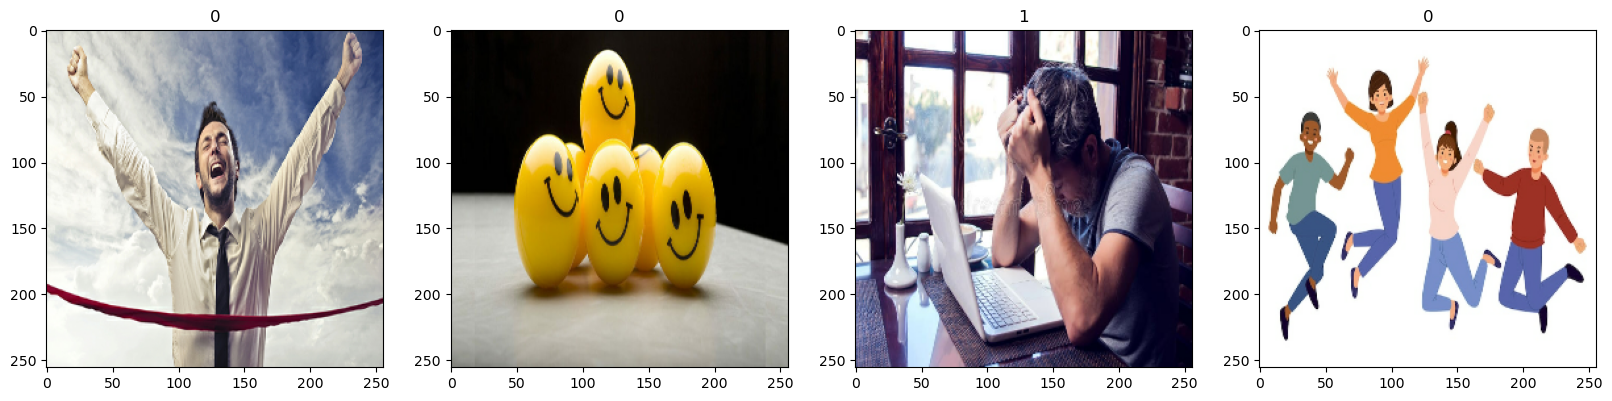

In [80]:
fig,ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data

In [81]:
len(data)

5

In [82]:
#from 5 batch 32 images each , train_size have 70%,validation size is 20%
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [83]:
test_size

1

In [84]:
#take -> defines how much data are we going to use in that particular partition
#skip -> skip batches already allocated

In [85]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Deep Model using keras sequential api

Deep learning model

In [86]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,Dropout

In [87]:
model = Sequential()

In [88]:
#16 - filters->that scans over an image and tries to condense/extract
#relevant information inside of that image to make an output classification
#3 by 3 pixels in size
#stride of 1 - move one pixel each time
#make your architectural decision
# model.add(Conv2D(16,(3,3),1,activation='relu',input_shape=(256,256,3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32,(3,3),1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16,(3,3),1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [89]:
# tf.optimizers.

In [90]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [91]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

Train

In [92]:
logdir = 'logs'

In [93]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [94]:
hist = model.fit(train, epochs = 20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 4s 888ms/step - loss: 2.0512 - accuracy: 0.4792 - val_loss: 0.9612 - val_accuracy: 0.6250
Epoch 2/20
3/3 [==============================] - 3s 786ms/step - loss: 0.8643 - accuracy: 0.5833 - val_loss: 0.7355 - val_accuracy: 0.4688
Epoch 3/20
3/3 [==============================] - 3s 719ms/step - loss: 0.6064 - accuracy: 0.6458 - val_loss: 0.6283 - val_accuracy: 0.6250
Epoch 4/20
3/3 [==============================] - 3s 738ms/step - loss: 0.6569 - accuracy: 0.5729 - val_loss: 0.6427 - val_accuracy: 0.5938
Epoch 5/20
3/3 [==============================] - 3s 740ms/step - loss: 0.6408 - accuracy: 0.5417 - val_loss: 0.5593 - val_accuracy: 0.6250
Epoch 6/20
3/3 [==============================] - 3s 741ms/step - loss: 0.5981 - accuracy: 0.5833 - val_loss: 0.5595 - val_accuracy: 0.7812
Epoch 7/20
3/3 [==============================] - 3s 714ms/step - loss: 0.5474 - accuracy: 0.7812 - val_loss: 0.4632 - val_accuracy: 0.9062
Epoch 8/20
3/3 [====

Plot Performance

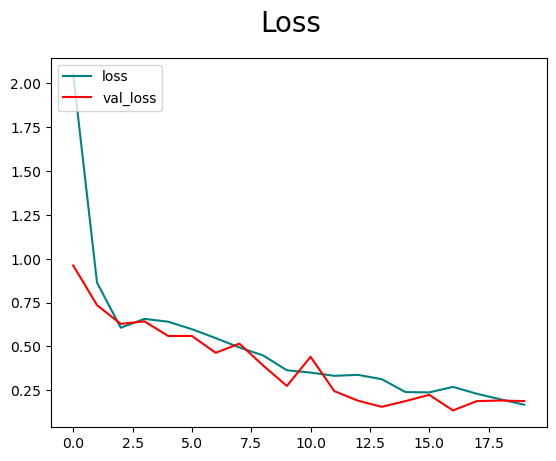

In [95]:
fig = plt.figure()
plt.plot(hist.history['loss'],color='teal',label = 'loss')
plt.plot(hist.history['val_loss'],color = 'red',label = 'val_loss')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc='upper left')
plt.show()

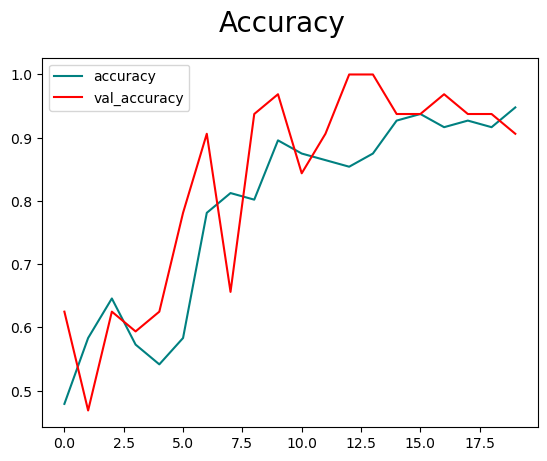

In [96]:
fig = plt.figure()
plt.plot(hist.history['accuracy'],color='teal',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'red',label = 'val_accuracy')
fig.suptitle('Accuracy',fontsize = 20)
plt.legend(loc='upper left')
plt.show()

EVALUATE PERFORMANCE

In [97]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [98]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [99]:
len(test)

1

In [100]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 172ms/step


In [101]:
print(f'Precision:{pre.result().numpy()},Recal:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:0.9375,Recal:0.8333333134651184,Accuracy:0.8666666746139526


Testing on new data

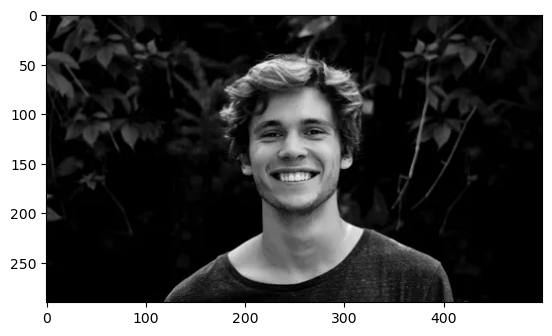

In [102]:
img = cv2.imread('Happy_guy.png')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

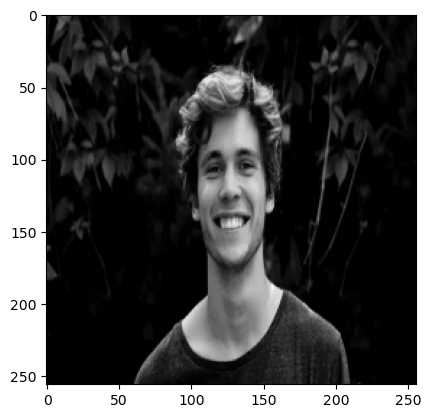

In [103]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [104]:
np.expand_dims(resize,0)

array([[[[ 1.535553 ,  1.535553 ,  1.535553 ],
         [ 5.2562866,  5.2562866,  5.2562866],
         [32.06256  , 32.06256  , 32.06256  ],
         ...,
         [ 1.       ,  1.       ,  1.       ],
         [ 3.7109375,  3.7109375,  3.7109375],
         [ 9.046875 ,  9.046875 ,  9.046875 ]],

        [[ 1.1418152,  1.1418152,  1.1418152],
         [12.17868  , 12.17868  , 12.17868  ],
         [26.62146  , 26.62146  , 26.62146  ],
         ...,
         [ 1.       ,  1.       ,  1.       ],
         [ 3.7109375,  3.7109375,  3.7109375],
         [ 9.046875 ,  9.046875 ,  9.046875 ]],

        [[ 1.5078735,  1.5078735,  1.5078735],
         [19.771759 , 19.771759 , 19.771759 ],
         [19.23468  , 19.23468  , 19.23468  ],
         ...,
         [ 1.       ,  1.       ,  1.       ],
         [ 3.7109375,  3.7109375,  3.7109375],
         [ 9.046875 ,  9.046875 ,  9.046875 ]],

        ...,

        [[ 0.       ,  0.       ,  0.       ],
         [ 0.       ,  0.       ,  0.       ]

In [105]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 31ms/step


In [106]:
yhat

array([[0.5928462]], dtype=float32)

In [107]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is happy')

Predicted class is Sad


 ### Saving the Model

In [108]:
from tensorflow.keras.models import load_model

In [109]:
#h5 is a serialization file format
model.save(os.path.join('myModels','happysadmodel.h5'))

C:\Users\Acer\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [110]:
new_model = load_model(os.path.join('models','happysadmodel.h5'))

In [111]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 94ms/step


In [112]:
if yhatnew > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
